# Stock Price Prediction using ARMA model

In [67]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
from datetime import datetime, timedelta
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category = ValueWarning)
warnings.filterwarnings("ignore", category = HessianInversionWarning)
warnings.filterwarnings("ignore", category = ConvergenceWarning)

# Simulate Buying and Selling Stock using ARMA

In [92]:
def run_simulation(returns, prices, amt, order, thresh, verbose = False, plot = True ):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt
    
    #go through dates
    for date, r in tqdm(returns.iloc[14:].items(), total = len(returns.iloc[14:])):
        #if stocks are currently holding, sell it
        if curr_holding:
            sell_prices = prices.loc[date]
            
            curr_holding = False
            ret = (sell_prices - buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(("s",date, ret))
            
            if verbose:
                print("Sold at $%s"%sell_prices)
                print("Predicted return :%s"%(round(pred,4)))
                print("Actual Return :%s"%(round(ret,4)))
                print("================================")
                
            continue
            
        #get  data till just before current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                
                #fit model
                model = ARIMA(curr_data, order).fit(maxiter=200)
                
                #get forecast
                pred = model.forecast()[0][0]
                
            except:
                pred = thresh - 1
                
        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order)== float and np.random.random() < order)or(type(order)==tuple and pred > thresh)
        or(order == "last" and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(("b", date))
            
            if verbose:
                print("Bought at $%s"%buy_price)
                
    if verbose:
        print("Total amount: $%s"%round(amt,2))
        
    #graph
    if plot:
        
        plt.figure(figsize = (10,4))
        plt.plot(prices[14:])
        
        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)
        
        for idx,event in enumerate(events_list):
            plt.axvline(event[1], color= "k", linestyle = "--", alpha = 0.4)
            if event[0] == "s":
                color = "green" if event[2] > 0 else "red"
                plt.fill_betweenx(range(*shaded_y_lims),event[1], events_list[idx-1][1], color = color, alpha = 0.4)
                
        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + "%"
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
        
    return amt

# Read Data

In [70]:
tickerSymbol = "AAPL"
data = yf.Ticker(tickerSymbol)

In [71]:
data.history()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-10-27,149.142338,149.511794,148.273611,148.633087,56094900,0.00,0
2021-10-28,149.601664,152.946773,149.501804,152.347656,100077900,0.00,0
2021-10-29,147.005454,149.721491,146.196637,149.581696,124850400,0.00,0
2021-11-01,148.772875,149.481832,147.584607,148.742920,74588300,0.00,0
2021-11-02,148.443358,151.349121,148.433363,149.801376,69122000,0.00,0
2021-11-03,150.170838,151.748538,149.601677,151.269241,54511500,0.00,0
2021-11-04,151.359097,152.207849,150.420465,150.740005,60394600,0.00,0
2021-11-05,151.889999,152.199997,150.059998,151.279999,65414600,0.22,0
2021-11-08,151.410004,151.570007,150.160004,150.440002,55020900,0.00,0


In [72]:
prices = data.history(start = "2021-01-01", end = "2021-04-01").Close
returns = prices.pct_change().dropna()

In [73]:
prices

Date
2020-12-31    131.877014
2021-01-04    128.617126
2021-01-05    130.207291
2021-01-06    125.824326
2021-01-07    130.117859
                 ...    
2021-03-25    120.030228
2021-03-26    120.647362
2021-03-29    120.826530
2021-03-30    119.343445
2021-03-31    121.582993
Name: Close, Length: 62, dtype: float64

In [74]:
returns

Date
2021-01-04   -0.024719
2021-01-05    0.012364
2021-01-06   -0.033661
2021-01-07    0.034123
2021-01-08    0.008631
                ...   
2021-03-25    0.004163
2021-03-26    0.005141
2021-03-29    0.001485
2021-03-30   -0.012275
2021-03-31    0.018766
Name: Close, Length: 61, dtype: float64

Text(0, 0.5, 'Prices')

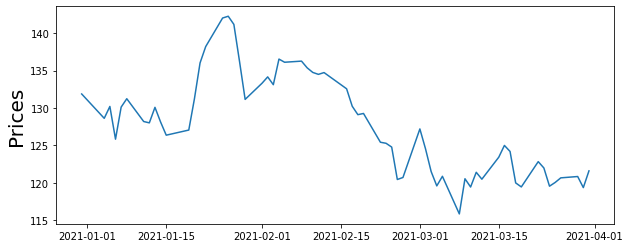

In [75]:
plt.figure(figsize = (10,4))
plt.plot(prices)
plt.ylabel("Prices", fontsize = 20)

Text(0, 0.5, 'Returns')

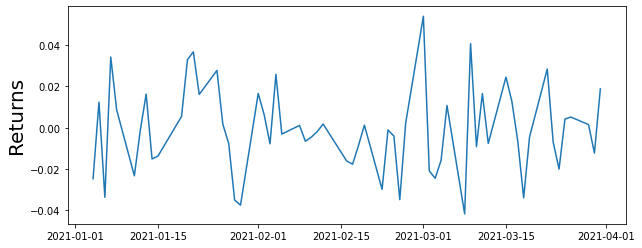

In [76]:
#plotting returns
plt.figure(figsize = (10,4))
plt.plot(returns)
plt.ylabel("Returns", fontsize = 20)

# ACF of returns

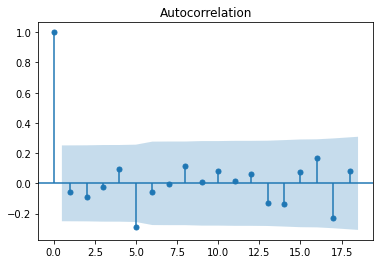

In [77]:
plot_acf(returns)
plt.show()

# PACF of returns

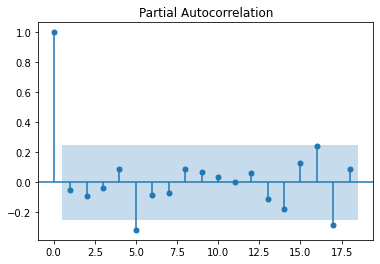

In [78]:
plot_pacf(returns)
plt.show()

# Baseline Model : Random Buying

In [93]:
#run_simulation(returns, prices, 100, 0.5, None, verbose = False)
run_simulation(returns, prices, 100, 0.5, None, verbose = True)

  2%|▉                                          | 1/47 [00:00<00:00, 781.50it/s]

Bought at $142.04432678222656
Sold at $142.28286743164062


UnboundLocalError: local variable 'pred' referenced before assignment

In [80]:
final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose = False, plot = False)for _ in range(500)]

100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 2099.54it/s]


100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 4969.43it/s]


100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 5188.78it/s]


100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 4092.51it/s]


100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 3391.23it/s]


/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'AVG :$95.44\nSD :$6.29')

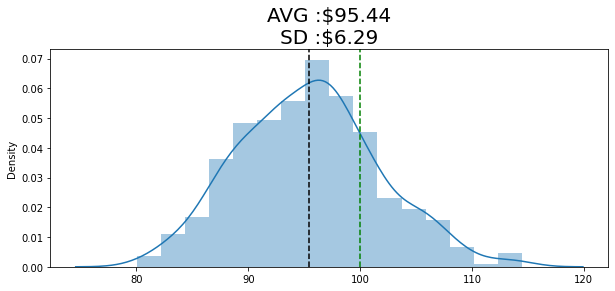

In [81]:
plt.figure(figsize = (10,4))
#sns.histplot(final_amts)
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color = "k", linestyle = "--")
plt.axvline(100,color = "g", linestyle = "--")
plt.title("AVG :$%s\nSD :$%s"%(round(np.mean(final_amts),2), round(np.std(final_amts),2)),fontsize = 20)

# If last return was positive then Buy

100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 4341.74it/s]


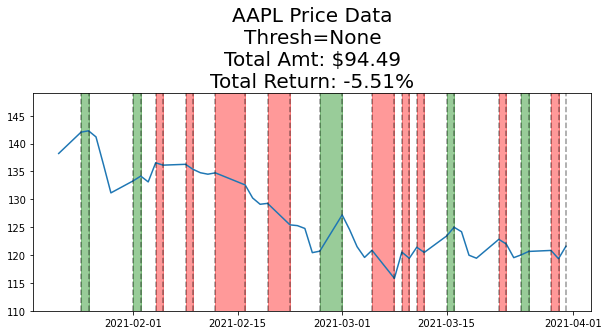

94.49321827952521

In [82]:
run_simulation(returns, prices, 100,"last", None, verbose = False)

# Lets Try AR(1) model

100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 2302.92it/s]


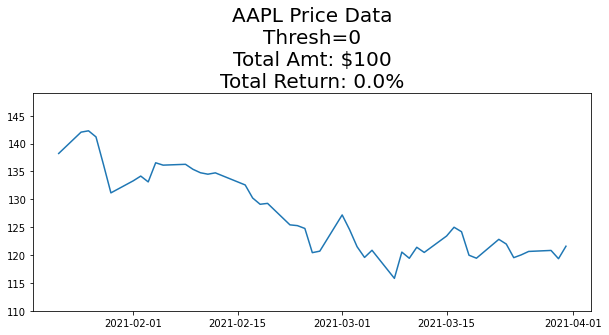

100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 3032.62it/s]


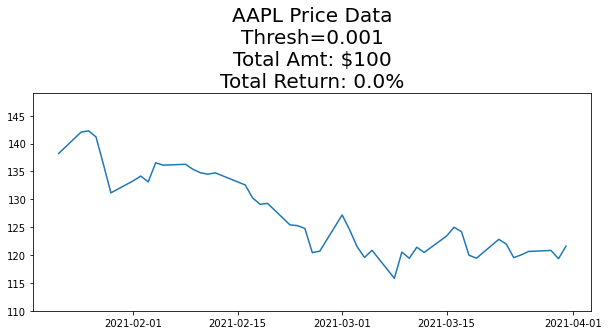

100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 2989.66it/s]


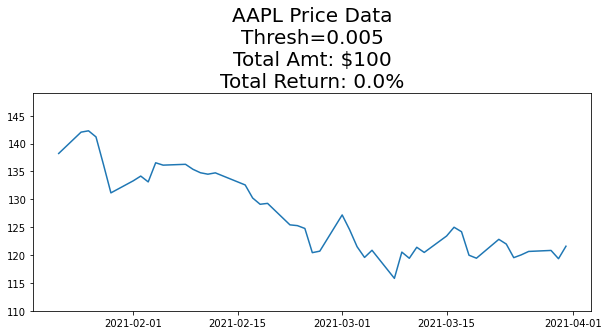

In [83]:
for thresh in [0,0.001, 0.005]:
    run_simulation(returns, prices, 100,(1,0),thresh, verbose = False)

# Try AR(5) model

  6%|██▊                                         | 3/47 [00:01<00:16,  2.74it/s]

At iterate   40    f= -2.48421D+00    |proj g|=  6.04850D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     57      1     0     0   1.332D-06  -2.484D+00
  F =  -2.4842086635004565     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.49516D+00    |proj g|=  6.31403D-02

At iterate    5    f= -2.50016D+00    |proj g|=  3.48642D-01

At iterate   10    f= -2.50154D+00    |proj g|=  1.00842D-02

At itera

 23%|██████████                                 | 11/47 [00:05<00:16,  2.17it/s]

At iterate   50    f= -2.46133D+00    |proj g|=  1.28582D-03

At iterate   55    f= -2.46133D+00    |proj g|=  2.62457D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     57     69      1     0     0   2.309D-06  -2.461D+00
  F =  -2.4613279553447955     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.00360D+00    |proj g|=  3.73550D+00

At iterate    5    f= -2.19782D+00    |proj g|=  2.62423D-01

At itera

 40%|█████████████████▍                         | 19/47 [00:08<00:12,  2.18it/s]

At iterate   40    f= -2.48448D+00    |proj g|=  6.48113D-03

At iterate   45    f= -2.48448D+00    |proj g|=  2.20286D-02

At iterate   50    f= -2.48448D+00    |proj g|=  6.68887D-04

At iterate   55    f= -2.48448D+00    |proj g|=  1.66800D-04

At iterate   60    f= -2.48448D+00    |proj g|=  2.91767D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     61     75      1     0     0   1.963D-05  -2.484D+00
  F =  -2.4844785367863018     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12


 62%|██████████████████████████▌                | 29/47 [00:12<00:06,  2.73it/s]

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.50889D+00    |proj g|=  1.87955D+00

At iterate    5    f= -2.56682D+00    |proj g|=  3.71519D-02

At iterate   10    f= -2.56707D+00    |proj g|=  1.00234D+00

At iterate   15    f= -2.57188D+00    |proj g|=  9.25824D-01

At iterate   20    f= -2.57210D+00    |proj g|=  7.97092D-02

At iterate   25    f= -2.57231D+00    |proj g|=  2.15043D-02

At iterate   30    f= -2.57234D+00    |proj g|=  7.78575D-02

At iterate   35    f= -2.57235D+00    |proj g|=  9.07718D-04

At iterate   40    f= -2.57235D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = num

 81%|██████████████████████████████████▊        | 38/47 [00:15<00:02,  3.04it/s]

Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     60      1     0     0   1.954D-06  -2.496D+00
  F =  -2.4956790324199245     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.46407D+00    |proj g|=  7.81384D-01

At iterate    5    f= -2.46448D+00    |proj g|=  1.01856D+00

At iterate   10    f= -2.47985D+00    |proj g|=  4.36519D+00

At iterate   15    f= -2.48693D+00    |proj g|=  2.43720D-01

At iterate   20    f= -2.49074D+00    |proj g|=  3.86848D-02

At iterate   25    f= -2.49129D+00    |proj g|=  4.55227D-03

At iterate   30    f= -2.49132D+00    |proj g|=  1.26663D-03

At iterate   35    f= -2.49132D+00    |proj g|=  5.77316D-07

           * * *

Tit   = to

100%|███████████████████████████████████████████| 47/47 [00:18<00:00,  2.52it/s]

Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     48      1     0     0   6.128D-06  -2.484D+00
  F =  -2.4840430815338355     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.46549D+00    |proj g|=  1.16949D-01

At iterate    5    f= -2.46648D+00    |proj g|=  2.20616D+00

At iterate   10    f= -2.46989D+00    |proj g|=  2.10257D-02

At iterate   15    f= -2.47111D+00    |proj g|=  2.16532D-01

At iterate   20    f= -2.47185D+00    |proj g|=  2.43863D-03

At iterate   25    f= -2.47185D+00    |proj g|=  3.83875D-02

At iterate   30    f= -2.47187D+00    |proj g|=  2.52576D-03

At iterate   35    f= -2.47187D+00    |proj g|=  1.37845D-04

At iterate   40    f= -2.471

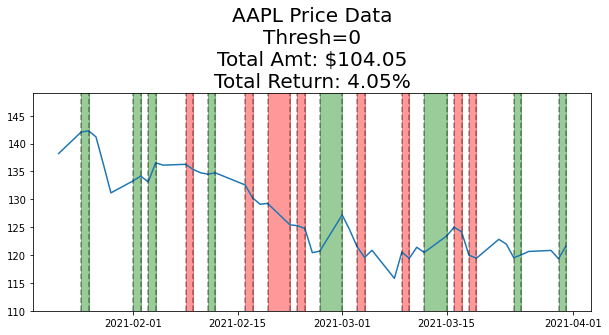

 17%|███████▍                                    | 8/47 [00:03<00:18,  2.13it/s]

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.00815D+00    |proj g|=  2.30548D+00

At iterate    5    f= -2.10792D+00    |proj g|=  4.36750D+00

At iterate   10    f= -2.33237D+00    |proj g|=  7.67836D-02

At iterate   15    f= -2.38879D+00    |proj g|=  5.47015D-01

At iterate   20    f= -2.39825D+00    |proj g|=  2.34910D-02

At iterate   25    f= -2.40213D+00    |proj g|=  1.07208D-02

At iterate   30    f= -2.40232D+00    |proj g|=  1.04016D-01

At iterate   35    f= -2.40261D+00    |proj g|=  5.62173D-04

At iterate   40    f= -2.40261D+00    |proj g|=  2.43805D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = num

 38%|████████████████▍                          | 18/47 [00:07<00:10,  2.77it/s]

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.34981D+00    |proj g|=  3.79445D+00

At iterate    5    f= -2.40554D+00    |proj g|=  1.05647D+01

At iterate   10    f= -2.45169D+00    |proj g|=  4.84869D-02

At iterate   15    f= -2.45199D+00    |proj g|=  1.12530D+00

At iterate   20    f= -2.45974D+00    |proj g|=  1.69666D+00

At iterate   25    f= -2.46118D+00    |proj g|=  1.14612D-01

At iterate   30    f= -2.46495D+00    |proj g|=  8.76974D-03

At iterate   35    f= -2.46516D+00    |proj g|=  7.47313D-04

At iterate   40    f= -2.46516D+00    |proj g|=  2.39954D-02

At iterate   45    f= -2.46516D+00    |proj g|=  1.56776D-02

At iterate   50    f= -2.46516D+00    |proj g|=  3.66498D-03

At iterate   55    f= -2.46516D+00    |proj g|=  2.84306D-04

At iterate   60    f= -2.46516D+00    |proj g|=  2.16493D-04

           * * *

Tit   = total number of iterations
Tnf   = total numb

 55%|███████████████████████▊                   | 26/47 [00:11<00:07,  2.69it/s]

Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     65      1     0     0   1.288D-06  -2.568D+00
  F =  -2.5684887784021533     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.50238D+00    |proj g|=  2.42108D+00

At iterate    5    f= -2.57631D+00    |proj g|=  7.88671D-02

At iterate   10    f= -2.57668D+00    |proj g|=  7.87874D-01

At iterate   15    f= -2.58221D+00    |proj g|=  5.47483D-01

At iterate   20    f= -2.58324D+00    |proj g|=  2.03290D-01


 72%|███████████████████████████████            | 34/47 [00:14<00:05,  2.38it/s]


At iterate    0    f= -2.47044D+00    |proj g|=  1.94620D+00

At iterate    5    f= -2.50060D+00    |proj g|=  1.53784D-01

At iterate   10    f= -2.50491D+00    |proj g|=  4.94480D-01

At iterate   15    f= -2.50591D+00    |proj g|=  5.78652D-02

At iterate   20    f= -2.50601D+00    |proj g|=  1.10307D-01

At iterate   25    f= -2.50607D+00    |proj g|=  6.04850D-04

At iterate   30    f= -2.50608D+00    |proj g|=  5.02265D-04

At iterate   35    f= -2.50608D+00    |proj g|=  1.35625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     58      1     0     0   2.487D-06  -2.506D+00
  F =  -2.50607865585

 94%|████████████████████████████████████████▎  | 44/47 [00:17<00:01,  2.90it/s]

At iterate    5    f= -2.47921D+00    |proj g|=  5.32135D-01

At iterate   10    f= -2.48089D+00    |proj g|=  8.00190D-01

At iterate   15    f= -2.48097D+00    |proj g|=  1.03945D-02

At iterate   20    f= -2.48101D+00    |proj g|=  2.65660D-02

At iterate   25    f= -2.48101D+00    |proj g|=  7.59437D-04

At iterate   30    f= -2.48101D+00    |proj g|=  6.89671D-05

At iterate   35    f= -2.48101D+00    |proj g|=  3.80584D-04

At iterate   40    f= -2.48101D+00    |proj g|=  1.01386D-04

At iterate   45    f= -2.48101D+00    |proj g|=  2.83329D-05

At iterate   50    f= -2.48101D+00    |proj g|=  3.37952D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

100%|███████████████████████████████████████████| 47/47 [00:18<00:00,  2.51it/s]


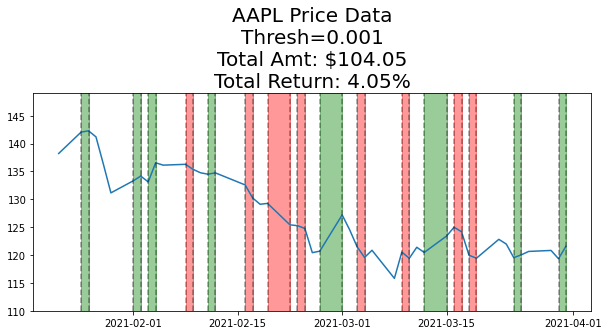

 13%|█████▌                                      | 6/47 [00:03<00:24,  1.65it/s]

At iterate   25    f= -2.50711D+00    |proj g|=  1.43975D-02

At iterate   30    f= -2.50711D+00    |proj g|=  1.04651D-02

At iterate   35    f= -2.50711D+00    |proj g|=  8.47322D-04

At iterate   40    f= -2.50711D+00    |proj g|=  4.82419D-03

At iterate   45    f= -2.50711D+00    |proj g|=  1.09246D-04

At iterate   50    f= -2.50711D+00    |proj g|=  3.23741D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     52     61      1     0     0   2.309D-06  -2.507D+00
  F =  -2.5071086313057038     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 28%|███████████▉                               | 13/47 [00:06<00:20,  1.68it/s]

At iterate   65    f= -2.40798D+00    |proj g|=  5.18696D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     68     81      1     0     0   2.043D-06  -2.408D+00
  F =  -2.4079795618481192     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.26658D+00    |proj g|=  3.94322D+00

At iterate    5    f= -2.39858D+00    |proj g|=  8.29836D+00

At iterate   10    f= -2.41466D+00    |proj g|=  6.55755D-02

At itera

 40%|█████████████████▍                         | 19/47 [00:10<00:18,  1.53it/s]

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.44858D+00    |proj g|=  3.13187D+00

At iterate    5    f= -2.52168D+00    |proj g|=  6.31474D+00

At iterate   10    f= -2.52821D+00    |proj g|=  1.32523D-01

At iterate   15    f= -2.52886D+00    |proj g|=  2.03846D+00

At iterate   20    f= -2.53561D+00    |proj g|=  8.06339D-01

At iterate   25    f= -2.53573D+00    |proj g|=  1.10338D-01

At iterate   30    f= -2.53723D+00    |proj g|=  1.47636D+00

At iterate   35    f= -2.53771D+00    |proj g|=  2.70810D-03

At iterate   40    f= -2.53775D+00    |proj g|=  2.15072D-02

At iterate   45    f= -2.53776D+00    |proj g|=  1.40029D-02

At iterate   50    f= -2.53776D+00    |proj g|=  3.99680D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates s

 51%|█████████████████████▉                     | 24/47 [00:13<00:14,  1.59it/s]

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     73     89      1     0     0   6.128D-06  -2.584D+00
  F =  -2.5838223609359985     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.48690D+00    |proj g|=  1.77971D+00

At iterate    5    f= -2.49159D+00    |proj g|=  2.92004D+00

At iterate   10    f= -2.55243D+00    |proj g|=  1.07535D-01

At iterate   15    f= -2.55300D+00    |proj g|=  5.32050D-01

At itera

 66%|████████████████████████████▎              | 31/47 [00:16<00:07,  2.07it/s]

At iterate    5    f= -2.50145D+00    |proj g|=  2.98996D-02

At iterate   10    f= -2.50522D+00    |proj g|=  2.34273D-01

At iterate   15    f= -2.50555D+00    |proj g|=  3.61439D-02

At iterate   20    f= -2.50571D+00    |proj g|=  1.28271D-02

At iterate   25    f= -2.50576D+00    |proj g|=  2.24139D-02

At iterate   30    f= -2.50576D+00    |proj g|=  3.21427D-03

At iterate   35    f= -2.50576D+00    |proj g|=  3.17186D-03

At iterate   40    f= -2.50576D+00    |proj g|=  4.57412D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     55      1     0     0   4.574D-06  -2.506D+00
  F =  -2.505761228584

 83%|███████████████████████████████████▋       | 39/47 [00:20<00:03,  2.01it/s]

At iterate   15    f= -2.47471D+00    |proj g|=  7.47812D-01

At iterate   20    f= -2.47773D+00    |proj g|=  4.22004D-01

At iterate   25    f= -2.47824D+00    |proj g|=  1.04215D-01

At iterate   30    f= -2.47828D+00    |proj g|=  6.09242D-02

At iterate   35    f= -2.47831D+00    |proj g|=  4.30913D-02

At iterate   40    f= -2.47831D+00    |proj g|=  1.17470D-03

At iterate   45    f= -2.47831D+00    |proj g|=  2.70317D-04

At iterate   50    f= -2.47831D+00    |proj g|=  1.13243D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     52     65      1     0     0   2.842D-06  -2.478D+00
  F =  -2.478310499968

 98%|██████████████████████████████████████████ | 46/47 [00:23<00:00,  2.21it/s]

At iterate   15    f= -2.47111D+00    |proj g|=  2.16532D-01

At iterate   20    f= -2.47185D+00    |proj g|=  2.43863D-03

At iterate   25    f= -2.47185D+00    |proj g|=  3.83875D-02

At iterate   30    f= -2.47187D+00    |proj g|=  2.52576D-03

At iterate   35    f= -2.47187D+00    |proj g|=  1.37845D-04

At iterate   40    f= -2.47187D+00    |proj g|=  7.77156D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     52      1     0     0   1.776D-07  -2.472D+00
  F =  -2.4718665543423319     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine

100%|███████████████████████████████████████████| 47/47 [00:24<00:00,  1.95it/s]


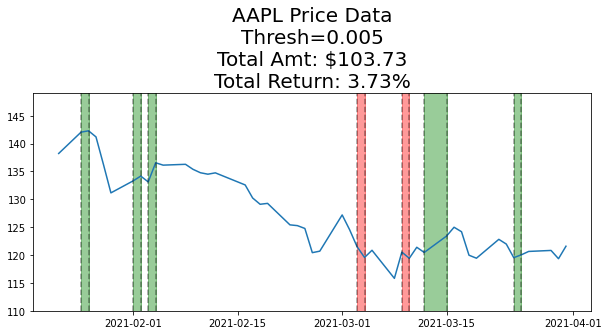

In [86]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,0),thresh, verbose = False )

# Lets try ARMA(5,5) model

  0%|                                                    | 0/47 [00:00<?, ?it/s]/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
 49%|█████████████████████                      | 23/47 [00:09<00:12,  1.85it/s]

At iterate   35    f= -2.51741D+00    |proj g|=  3.07544D-02

At iterate   40    f= -2.51741D+00    |proj g|=  1.24745D-04

At iterate   45    f= -2.51741D+00    |proj g|=  2.94507D-03

At iterate   50    f= -2.51741D+00    |proj g|=  1.11022D-04

At iterate   55    f= -2.51741D+00    |proj g|=  7.99361D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     57     71      1     0     0   4.752D-06  -2.517D+00
  F =  -2.5174097323436957     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           12


 64%|███████████████████████████▍               | 30/47 [00:21<00:21,  1.25s/it]

At iterate   60    f= -2.60225D+00    |proj g|=  4.65576D-01

At iterate   65    f= -2.60251D+00    |proj g|=  1.02552D-02

At iterate   70    f= -2.60251D+00    |proj g|=  2.85975D-02

At iterate   75    f= -2.60264D+00    |proj g|=  1.01776D-01

At iterate   80    f= -2.60266D+00    |proj g|=  1.59908D-03

At iterate   85    f= -2.60266D+00    |proj g|=  1.18649D-02

At iterate   90    f= -2.60266D+00    |proj g|=  1.47699D-02

At iterate   95    f= -2.60267D+00    |proj g|=  1.01139D-02

At iterate  100    f= -2.60268D+00    |proj g|=  5.93112D-03

At iterate  105    f= -2.60269D+00    |proj g|=  3.31448D-02

At iterate  110    f= -2.60269D+00    |proj g|=  3.80140D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F    

 77%|████████████████████████████████▉          | 36/47 [00:36<00:20,  1.87s/it]/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:728: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
 83%|███████████████████████████████████▋       | 39/47 [00:38<00:10,  1.30s/it]

At iterate   85    f= -2.52896D+00    |proj g|=  5.85443D-03

At iterate   90    f= -2.52905D+00    |proj g|=  1.55028D-01

At iterate   95    f= -2.52911D+00    |proj g|=  6.52309D-03

At iterate  100    f= -2.52911D+00    |proj g|=  5.08593D-02

At iterate  105    f= -2.52911D+00    |proj g|=  1.43413D-02

At iterate  110    f= -2.52911D+00    |proj g|=  4.04121D-05

At iterate  115    f= -2.52911D+00    |proj g|=  1.34199D-03

At iterate  120    f= -2.52911D+00    |proj g|=  5.09992D-04

At iterate  125    f= -2.52911D+00    |proj g|=  2.06848D-03

At iterate  130    f= -2.52911D+00    |proj g|=  1.00808D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
 91%|███████████████████████████████████████▎   | 43/47 [00:52<00:09,  2.40s/it]

At iterate    5    f= -2.47592D+00    |proj g|=  2.47023D+00

At iterate   10    f= -2.47688D+00    |proj g|=  1.29835D-01

At iterate   15    f= -2.47730D+00    |proj g|=  1.50309D+00

At iterate   20    f= -2.48023D+00    |proj g|=  4.69556D-02

At iterate   25    f= -2.48114D+00    |proj g|=  4.15667D-01

At iterate   30    f= -2.48796D+00    |proj g|=  2.09319D-01

At iterate   35    f= -2.48900D+00    |proj g|=  3.60312D+00

At iterate   40    f= -2.48992D+00    |proj g|=  5.83602D-02

At iterate   45    f= -2.49059D+00    |proj g|=  5.13947D-01

At iterate   50    f= -2.49131D+00    |proj g|=  6.10146D-01

At iterate   55    f= -2.49461D+00    |proj g|=  4.42726D-02

At iterate   60    f= -2.49923D+00    |proj g|=  8.95907D-01

At iterate   65    f= -2.50099D+00    |proj g|=  7.65888D-02

At iterate   70    f= -2.50514D+00    |proj g|=  4.82641D-02

At iterate   75    f= -2.50781D+00    |proj g|=  5.80731D-01

At iterate   80    f= -2.51319D+00    |proj g|=  6.60537D-01

At itera

100%|███████████████████████████████████████████| 47/47 [01:03<00:00,  1.35s/it]


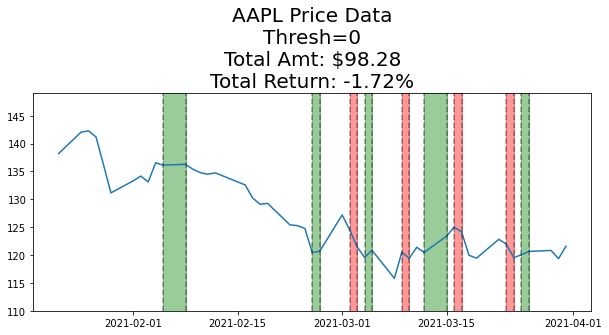

  0%|                                                    | 0/47 [00:00<?, ?it/s]/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
 13%|█████▌                                      | 6/47 [00:00<00:00, 57.52it/s]

At iterate    0    f= -2.43317D+00    |proj g|=  4.56934D-01

At iterate    5    f= -2.47678D+00    |proj g|=  1.74616D+00

At iterate   10    f= -2.49727D+00    |proj g|=  1.22899D+00

At iterate   15    f= -2.54591D+00    |proj g|=  3.17712D-01

At iterate   20    f= -2.54884D+00    |proj g|=  6.17069D-01

At iterate   25    f= -2.55046D+00    |proj g|=  1.44064D-02

At iterate   30    f= -2.55051D+00    |proj g|=  2.76043D-01

At iterate   35    f= -2.55118D+00    |proj g|=  1.19051D-01

At iterate   40    f= -2.55122D+00    |proj g|=  2.90875D-02

At iterate   45    f= -2.55128D+00    |proj g|=  1.36938D-02

At iterate   50    f= -2.55193D+00    |proj g|=  3.56498D-01

At iterate   55    f= -2.55288D+00    |proj g|=  9.27027D-03

At iterate   60    f= -2.55298D+00    |proj g|=  2.45862D-02

At iterate   65    f= -2.55438D+00    |proj g|=  1.66271D-02

At iterate   70    f= -2.55442D+00    |proj g|=  1.96931D-03

At iterate   75    f= -2.55443D+00    |proj g|=  5.58460D-03

At itera

 55%|███████████████████████▊                   | 26/47 [00:13<00:15,  1.32it/s]

At iterate  135    f= -2.58794D+00    |proj g|=  2.23160D-02

At iterate  140    f= -2.58794D+00    |proj g|=  5.34924D-02

At iterate  145    f= -2.58794D+00    |proj g|=  5.38636D-03

At iterate  150    f= -2.58794D+00    |proj g|=  7.35056D-02

At iterate  155    f= -2.58795D+00    |proj g|=  1.81733D-01

At iterate  160    f= -2.58796D+00    |proj g|=  1.10589D-02

At iterate  165    f= -2.58803D+00    |proj g|=  1.74994D-01

At iterate  170    f= -2.58840D+00    |proj g|=  2.03767D-01

At iterate  175    f= -2.58841D+00    |proj g|=  1.32601D-03

At iterate  180    f= -2.58841D+00    |proj g|=  4.36984D-03

At iterate  185    f= -2.58841D+00    |proj g|=  3.38396D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F    

 66%|████████████████████████████▎              | 31/47 [00:25<00:23,  1.49s/it]

At iterate  105    f= -2.52021D+00    |proj g|=  1.34557D-01

At iterate  110    f= -2.52024D+00    |proj g|=  6.50333D-02

At iterate  115    f= -2.52026D+00    |proj g|=  1.77587D-03

At iterate  120    f= -2.52026D+00    |proj g|=  1.38001D-03

At iterate  125    f= -2.52026D+00    |proj g|=  5.62217D-05

At iterate  130    f= -2.52026D+00    |proj g|=  2.25908D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11    131    163      1     0     0   2.258D-04  -2.520D+00
  F =  -2.5202581076164714     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 77%|████████████████████████████████▉          | 36/47 [00:34<00:18,  1.66s/it]/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:728: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
 83%|███████████████████████████████████▋       | 39/47 [00:36<00:09,  1.22s/it]/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/robin/anaconda3/envs/robin/lib/py

F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     84    105      1     0     0   3.579D-05  -2.560D+00
  F =  -2.5599130538252983     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.53420D+00    |proj g|=  2.60973D+00

At iterate    5    f= -2.56650D+00    |proj g|=  3.71072D-01

At iterate   10    f= -2.56722D+00    |proj g|=  1.25765D-02

At iterate   15    f= -2.56778D+00    |proj g|=  1.78309D-01

At iterate   20    f= -2.56980D+00    |proj g|=  3.17299D-02

At iterate   25    f= -2.57009D+00    |proj g|=  2.51658D-01

At iterate   30    f= -2.57059D+00    |proj g|=  1.52914D-02

At iterate   35    f= -2.57060D+00    |proj g|=  1.69972D-02

At iterate   40    f= -2.57063D+00    |proj g|=  9.24331D-02

At iterate 

 96%|█████████████████████████████████████████▏ | 45/47 [00:53<00:04,  2.02s/it]

   11    191    268      2     0     0   4.707D-05  -2.522D+00
  F =  -2.5224054747012739     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.48413D+00    |proj g|=  3.33032D+00

At iterate    5    f= -2.48465D+00    |proj g|=  1.61750D+00

At iterate   10    f= -2.48565D+00    |proj g|=  6.58476D-02

At iterate   15    f= -2.48579D+00    |proj g|=  7.89909D-01

At iterate   20    f= -2.48851D+00    |proj g|=  1.69514D+00

At iterate   25    f= -2.49217D+00    |proj g|=  1.70489D-01

At iterate   30    f= -2.50360D+00    |proj g|=  1.15784D-01

At iterate   35    f= -2.50687D+00    |proj g|=  2.13970D-01

At iterate   40    f= -2.50757D+00    |proj g|=  1.87522D-01

At iterate   45    f= -2.50963D+00    |proj g|=  7.92280D-02

At iterate   50    f= -2.50984D+00    |proj g|=  1.9793

100%|███████████████████████████████████████████| 47/47 [01:00<00:00,  1.28s/it]


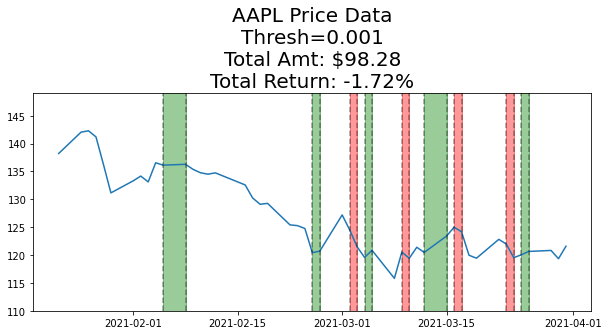

  0%|                                                    | 0/47 [00:00<?, ?it/s]/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
 40%|█████████████████▍                         | 19/47 [00:04<00:06,  4.52it/s]

At iterate   45    f= -2.56016D+00    |proj g|=  4.45309D-02

At iterate   50    f= -2.56018D+00    |proj g|=  1.69638D-03

At iterate   55    f= -2.56018D+00    |proj g|=  2.48219D-03

At iterate   60    f= -2.56018D+00    |proj g|=  1.37277D-03

At iterate   65    f= -2.56018D+00    |proj g|=  6.30287D-03

At iterate   70    f= -2.56018D+00    |proj g|=  1.33644D-03

At iterate   75    f= -2.56018D+00    |proj g|=  4.30500D-04

At iterate   80    f= -2.56018D+00    |proj g|=  8.39377D-03

At iterate   85    f= -2.56018D+00    |proj g|=  8.28404D-04

At iterate   90    f= -2.56018D+00    |proj g|=  5.59996D-04

At iterate   95    f= -2.56018D+00    |proj g|=  1.42109D-03

At iterate  100    f= -2.56018D+00    |proj g|=  5.42411D-04

At iterate  105    f= -2.56018D+00    |proj g|=  1.68487D-04

At iterate  110    f= -2.56018D+00    |proj g|=  1.16795D-03

At iterate  115    f= -2.56018D+00    |proj g|=  1.14575D-05

At iterate  120    f= -2.56018D+00    |proj g|=  8.74856D-06

        

 60%|█████████████████████████▌                 | 28/47 [00:15<00:16,  1.18it/s]

At iterate  105    f= -2.61006D+00    |proj g|=  8.53657D-02

At iterate  110    f= -2.61020D+00    |proj g|=  4.64451D-02

At iterate  115    f= -2.61036D+00    |proj g|=  4.46795D-02

At iterate  120    f= -2.61052D+00    |proj g|=  6.35141D-02

At iterate  125    f= -2.61060D+00    |proj g|=  1.34279D-01

At iterate  130    f= -2.61069D+00    |proj g|=  2.22220D-02

At iterate  135    f= -2.61072D+00    |proj g|=  7.86015D-02

At iterate  140    f= -2.61078D+00    |proj g|=  4.27192D-02

At iterate  145    f= -2.61083D+00    |proj g|=  9.31414D-02

At iterate  150    f= -2.61088D+00    |proj g|=  8.01414D-02

At iterate  155    f= -2.61090D+00    |proj g|=  1.31506D-01

At iterate  160    f= -2.61095D+00    |proj g|=  5.75865D-02

At iterate  165    f= -2.61096D+00    |proj g|=  3.14011D-02

At iterate  170    f= -2.61105D+00    |proj g|=  1.26129D-01

At iterate  175    f= -2.61115D+00    |proj g|=  6.15522D-02

At iterate  180    f= -2.61121D+00    |proj g|=  8.92105D-02

At itera

 70%|██████████████████████████████▏            | 33/47 [00:27<00:20,  1.50s/it]

At iterate  130    f= -2.52831D+00    |proj g|=  4.90591D-02

At iterate  135    f= -2.52856D+00    |proj g|=  1.74038D-01

At iterate  140    f= -2.52858D+00    |proj g|=  6.70661D-02

At iterate  145    f= -2.52863D+00    |proj g|=  9.73791D-02

At iterate  150    f= -2.52920D+00    |proj g|=  2.11312D-01

At iterate  155    f= -2.52922D+00    |proj g|=  8.82050D-04

At iterate  160    f= -2.52922D+00    |proj g|=  1.25517D-02

At iterate  165    f= -2.52922D+00    |proj g|=  4.89403D-02

At iterate  170    f= -2.52922D+00    |proj g|=  3.11446D-02

At iterate  175    f= -2.52922D+00    |proj g|=  9.41132D-03

At iterate  180    f= -2.52922D+00    |proj g|=  1.42692D-02

At iterate  185    f= -2.52922D+00    |proj g|=  1.83222D-03

At iterate  190    f= -2.52923D+00    |proj g|=  1.12973D-01

At iterate  195    f= -2.52933D+00    |proj g|=  2.93691D-01

At iterate  200    f= -2.52934D+00    |proj g|=  1.54952D-02

           * * *

Tit   = total number of iterations
Tnf   = total num

 77%|████████████████████████████████▉          | 36/47 [00:33<00:18,  1.68s/it]/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:728: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
 83%|███████████████████████████████████▋       | 39/47 [00:35<00:09,  1.18s/it]/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/robin/anaconda3/envs/robin/lib/py

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11    153    183      1     0     0   1.279D-05  -2.571D+00
  F =  -2.5711138074098296     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.36213D+00    |proj g|=  6.09805D+00

At iterate    5    f= -2.36504D+00    |proj g|=  1.55905D+00

At iterate   10    f= -2.37786D+00    |proj g|=  3.88413D+00

At iterate   15    f= -2.38007D+00    |proj g|=  2.46850D+00

At iterate   20    f= -2.40785D+00    |proj g|=  1.16058D+01

At iterate   25    f= -2.41775D+00    |proj g|=  5.16613D-01

At iterate   30    f= -2.42819D+00    |proj g|=  8.68193D+00

At iterate   35    f= -2.47616D+00    |proj g|=  6.93793D-02

At iterate   40    f= -2.48285D+00    |proj g|=  1.14364D+00

At iterate   45    f= -2.48636D+00    |proj g|=  5.01489D-0

 96%|█████████████████████████████████████████▏ | 45/47 [00:58<00:05,  2.85s/it]

At iterate  190    f= -2.52907D+00    |proj g|=  1.94768D-01

At iterate  195    f= -2.52994D+00    |proj g|=  7.48204D-01

At iterate  200    f= -2.53099D+00    |proj g|=  8.51096D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11    200    263      2     0     0   8.511D-01  -2.531D+00
  F =  -2.5309917489874993     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.48323D+00    |proj g|=  2.12610D+00

At itera

100%|███████████████████████████████████████████| 47/47 [01:05<00:00,  1.39s/it]


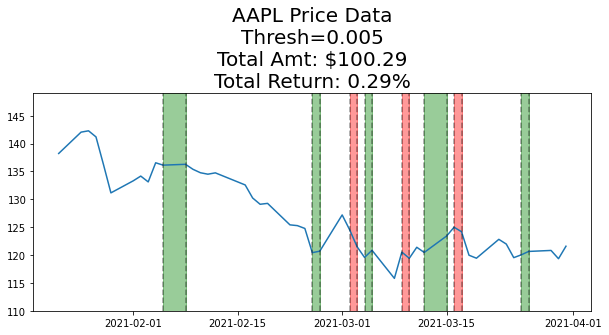

In [87]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,5), thresh, verbose=False)